In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform,he_uniform
from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model,normalize
from sklearn.metrics import roc_curve,roc_auc_score
import torch.nn.functional as F
import tensorflow as tf
import random

#### Reading MNIST data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = tf.keras.datasets.mnist.load_data(path="mnist.npz")


11493376/11490434 [==============================] - 0s 0us/step


#### Reshaping data in a form compatible with input shape required by inbuilt function

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

#### Preparing triplet pairs in advance so that we can use it directly whenever required instead of computing it afresh every time

In [ ]:
pairs = np.zeros((60000,4))

for i in range(60000):
    # find match
    idx = np.where(y_train==y_train[i])
    match = random.randint(0, idx[0].shape[0]-1)
    match = idx[0][match]
    # non match
    idx = np.where(y_train!=y_train[i])
    non_match = random.randint(0, idx[0].shape[0]-1)
    non_match = idx[0][non_match]

    pairs[i][0] = i 
    pairs[i][1] = match
    pairs[i][2] = non_match 
    pairs[i][3] = y_train[i]



#### Displaying 5 sample triplets formed from triplet dataset

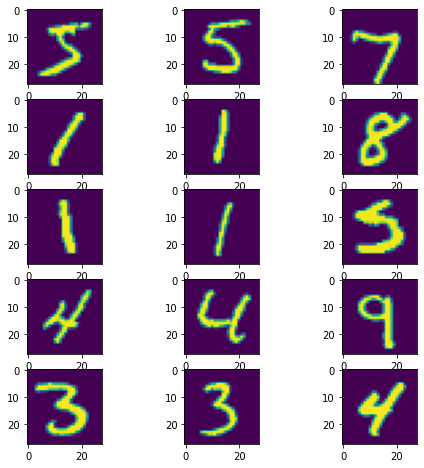

In [ ]:

idx = random.sample(range(0, 59000), 5)
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 5
for i in range(0, columns*rows, 3 ):
      fig.add_subplot(rows, columns, i+1) 
      plt.imshow( x_train_origin[int(pairs[i][0])] )  
      fig.add_subplot(rows, columns, i+2) 
      plt.imshow( x_train_origin[int(pairs[i][1])] )
      fig.add_subplot(rows, columns, i+3) 
      plt.imshow( x_train_origin[int(pairs[i][2])] ) 

plt.show()

### Siamese network code

In [ ]:
network = Sequential()
network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=(28,28,1),
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
network.add(MaxPooling2D())
network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
network.add(MaxPooling2D())
network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
network.add(Flatten())
network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
network.add(Dense(10, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
#Force the encoding to live on the d-dimentional hypershpere
network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    


#### Function to get a random batch of triplets to feed for training

In [ ]:

def get_indices():
  anchor_class = np.random.randint(0, 10)
  idx = np.where(pairs[:,3]==anchor_class)
  anchor_idx = idx[0][np.random.randint(0, idx[0].shape[0])]
  pos = idx[0][np.random.randint(0, idx[0].shape[0])]
    
  idx2 = np.where(pairs[:,3]!=anchor_class)
  neg = idx2[0][np.random.randint(0, idx2[0].shape[0])]
  return anchor_idx, pos, neg

def make_batch(batch_sz, loss_type="triplet"):
  
    triplets = [np.zeros((batch_sz,28, 28, 1)) for i in range(3)]
    pairs_batch = [np.zeros((batch_sz,28, 28, 1)) for i in range(2)]
    labels = np.zeros(batch_sz)
    for i in range(batch_sz):
      anchorIdx, posIdx, negIdx = get_indices()
      if (loss_type=="triplet"):
        triplets[0][i,:,:,:] = x_train[anchorIdx]
        triplets[1][i,:,:,:] = x_train[posIdx]
        triplets[2][i,:,:,:] = x_train[negIdx]

      elif (loss_type=="contrastive"):
        pairs_batch[0][i,:,:,:] = x_train[anchorIdx]
        pairs_batch[1][i,:,:,:] = x_train[posIdx]
        labels[i] = 1
        pairs_batch[0][i+1,:,:,:] = x_train[anchorIdx]
        pairs_batch[1][i+1,:,:,:] = x_train[negIdx]
        labels[i+1] = 0
        i += 1

    if (loss_type=="triplet"):
      return triplets
    elif (loss_type=="contrastive"):
      return pairs_batch
  


#### Preparing the model to accept input in required format and use the custom loss function

In [ ]:
def build_model(input_shape, network, loss_type="triplet", margin=0.2):
     
    if (loss_type=="triplet"):
      # Define the tensors for the three input images
      anchor_input = Input(input_shape, name="anchor_input")
      positive_input = Input(input_shape, name="positive_input")
      negative_input = Input(input_shape, name="negative_input") 
      
      # Generate the encodings (feature vectors) for the three images
      encoded_a = network(anchor_input)
      encoded_p = network(positive_input)
      encoded_n = network(negative_input)
      #TripletLoss Layer
      loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
      
      # Connect the inputs with the outputs
      network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)

    elif (loss_type=="contrastive"):
      loss_layer = ContrastiveLoss(name='contrastive_loss_layer')([])

    return network_train


#### Triplet Loss 

In [ ]:
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = K.sum(K.square(anchor-positive), axis=-1)
        n_dist = K.sum(K.square(anchor-negative), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

#### Contrastive Loss

In [ ]:
class ContrastiveLoss():

      def __init__(self, margin=2.0):
            super(ContrastiveLoss, self).__init__()
            self.margin = margin

      def forward(self, output1, output2, label):
        euc_dist = K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))
        contra_loss = tf.math.minimum(label * euc_dist**2 , (1-label)* tf.math.maximum((0, self.margin - euc_dist)))
        return contra_loss

#### Model initialization

In [ ]:
network_train = build_model((28,28,1),network, loss_type="triplet",)
optimizer = Adam(lr = 0.00006)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='02 model.png')
print(network_train.metrics_names)
n_iteration=0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 10)           4688522     anchor_input[0][0]               
                                                                 positive_input[0][0]         

In [ ]:
# Hyper parameters
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 800 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

In [ ]:
print
t_start = time.time()
dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = make_batch(32)
    loss = network_train.train_on_batch(triplets, None)
    #print("Epoch : ",i,"  Train Loss : ",loss)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("Epoch : ",i,"  Train Loss : ",loss)


Epoch :  100   Train Loss :  5.864620685577393
Epoch :  200   Train Loss :  6.249868392944336
Epoch :  300   Train Loss :  5.813228607177734
Epoch :  400   Train Loss :  7.108962059020996
Epoch :  500   Train Loss :  5.7896504402160645
Epoch :  600   Train Loss :  5.468629837036133
Epoch :  700   Train Loss :  6.287116050720215
Epoch :  800   Train Loss :  5.658538341522217


#### Generating embedding for input image

In [ ]:
def get_embeddings(network,X,Y):
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    embeddings = network.predict(X)
    return embeddings

#### Classifying using following technique : 
- Computing average distance of test sample with each class
- whichever class its closest to, is predicted as output

In [ ]:
def classify(X_test, X_train, y_train, y_test):
  y_pred = np.zeros(X_test.shape[0])
  for index, row in enumerate(X_test):
      avg_class_dist = np.zeros(10)
      for i in range(10):
          idx = np.where(y_train == i)
          #print(idx[0].shape, X_train[idx].shape)
          #print(idx[0])
          dist = np.sum((X_train[idx[0]] - row)**2, axis=1)
          #print(dist.shape)
          avg_dist = np.sum(dist)/dist.shape[0]
          avg_class_dist[i] = avg_dist
      y_pred[index] = np.argmin(avg_class_dist)
  return y_pred



### Calculating embedding of train and test data

In [ ]:
emb_test = get_embeddings(network2,x_test, y_test)
emb_train = get_embeddings(network2,x_train[:30000], y_train[:30000])
print(emb_train.shape, emb_test.shape)

(30000, 128) (10000, 128)


In [ ]:
out = classify(emb_test, emb_train, y_train[:30000], y_test)

In [1]:
y_pred=(out==y_test)
corr = np.where(a==True)
print("Accuracy : ",corr[0].shape/10000 * 100)


Accuracy :  76.55


#### Decision tree for classification using embeddings

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion="entropy", max_depth=8, min_samples_leaf=10)
clf.fit(emb_train, y_train[:30000])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y = clf.predict(emb_test)

In [2]:
acc = (np.where((y==y_test)==True))[0].shape / 10000 * 100
print("Accuracy : ",acc) 

Accuracy :  94.47
